<a href="https://colab.research.google.com/github/yuvalofek/FrequentistML/blob/master/FreqML4_gradient_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frequentist ML Assignment 4 - Gradient Boosted Trees**

Yuval Epstain Ofek & Theo Jaquenoud


---



**The Prompt:**
For this assignment, you will learn how to use and tune a common gradient boosted tree package XGBoost:

https://xgboost.readthedocs.io/en/latest/

1. First, select one of the datasets from section 10.14 of the test(either California Housing or New Zealand Fish) and replicate the analysis, including the plots. You don't have to do the maps. 

2. Next, select a dataset of your choice and perform a similar analysis. You can perform classification or regresssion, your choice. This should be a more complicated, and if you want, messier, dataset than the ones we've looked at so far. Use the built-in functions that come with the xgboost package to tune the model and optimize your performance, and determine the feature importance.  As this assignment is more focused on using a library, I will be expecting a more thoughtful analysis of the results.

For some more details on XGBoost, you can have a look at : https://arxiv.org/pdf/1603.02754v3.pdf and https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5

If you wish to get your hands a bit dirty on tree-related algorithms, there are 2 stretch goals available as well.

* Stretch goal #1, 3 points: Implement a basic tree algorithm for both regression and classification. It must work for several loss functions: mean-squared error, misclassification, Gini index, and cross-entropy. You do not have to implement any pruning, but the # of nodes should be a parameter. Select a dataset to test your algorithm on, and tune it using cross-validation to select the optimal # of nodes. Compare against a baseline.

* Stretch goal #2, 3 points: Use a simple tree method, (like your tree from stretch goal #1) and implement algorithm 10.3. Select a dataset, tune your algorithm and compare it against a baseline

Summary:
* get dataset (either California Housing or New Zealand Fish)
* Train gradient boost
* Plot Absolute Error vs iteration for training and test
* Bar plot relative importance of features
* repeat above for a chosen dataset



Stretch Goals:
* Implement a basic tree algorithm that works with a bouple of losses 
* Select a dataset
* Tune using cross validation to get # of nodes
* Compare with baseline


* Using a simple tree based methid implement 10.3
* Select dataset
* Tune algorithm
* Compare with baseline

##Imports

In [ ]:
#import stuff
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn import *
import sklearn

from tabulate import tabulate
from sklearn.model_selection import train_test_split  #for spliting data
from sklearn.model_selection  import GridSearchCV, StratifiedKFold, RandomizedSearchCV

SEED = 123
np.random.seed(SEED)

## California Housing Dataset

In [ ]:
#sklearn has the california housing dataset already, lucky us
sklearn_housing = sklearn.datasets.fetch_california_housing()
cali = pd.DataFrame(sklearn_housing['data'],
                    columns = sklearn_housing['feature_names'])
cal = cali.to_numpy()
cali.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
def train_val_test_split(X,y, test_size, val_size, random_state = None):
  '''Extended train_test_split to also provide a validation set'''

  #We want to split the data in 3, but the train_test_split only splits in 2. 
  #This means we need to split once to get a testing set and an intermediate set 
  #which we split again to get the validation and training sets. because 
  #train_test_split takes a percentage to determine the split, we first determine 
  #the relative percentage of the intermediate set needed to generate the 
  #necessary number of samples in the validation set:
  rel_val_percent = np.round((val_size)/(1-test_size), 2)

  #splitting the data
  X_inter, X_test, y_inter, y_test = train_test_split(X,
                                                      y,
                                                      test_size = test_size,
                                                      random_state = random_state
                                                      )
  X_train, X_val, y_train, y_val = train_test_split(X_inter,
                                                      y_inter,
                                                      test_size = rel_val_percent,
                                                      random_state = random_state
                                                      )
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
#data splitting conditions
PERCENT_VAL = 0.10
PERCENT_TEST = 0.10
random_state = 25  #for reproducibility

#Median income is the 2nd column (column 1)
split_data = train_val_test_split(cal[:,1:],
                                  cal[:,0],
                                  PERCENT_TEST,
                                  PERCENT_VAL,
                                  random_state)
#unpacking
X_train, X_val, X_test, y_train, y_val, y_test = split_data

#printing sizes to check
print('Input length:', len(cal))
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))

Input length: 20640
Number of training samples: 16532
Number of validation samples: 2044
Number of testing samples: 2064


In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 4, 6]
        }

In [ ]:
xgb1 = xgb.XGBRegressor(learning_rate=0.02,
                        n_estimators=800,
                        silent=True,
                        nthread=1)

In [ ]:
#This one takes a WHILE to run
random_search = RandomizedSearchCV(xgb1,
                                   param_distributions=params,
                                   n_jobs = -1,
                                   verbose=1,
                                   random_state=SEED)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.02, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=800,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=True, subsample=1,
                                 

In [ ]:
best_xgb = random_search.best_estimator_
eval_sets = [(X_train, y_train), (X_val, y_val)]
best_xgb.fit(X_train, y_train,
             eval_metric='mae',
             eval_set=eval_sets,
             verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=800,
             n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [ ]:
baseline_abserr = np.mean( np.abs(y_val - y_train.mean()) )
baseline_abserr

1.3795885236744205

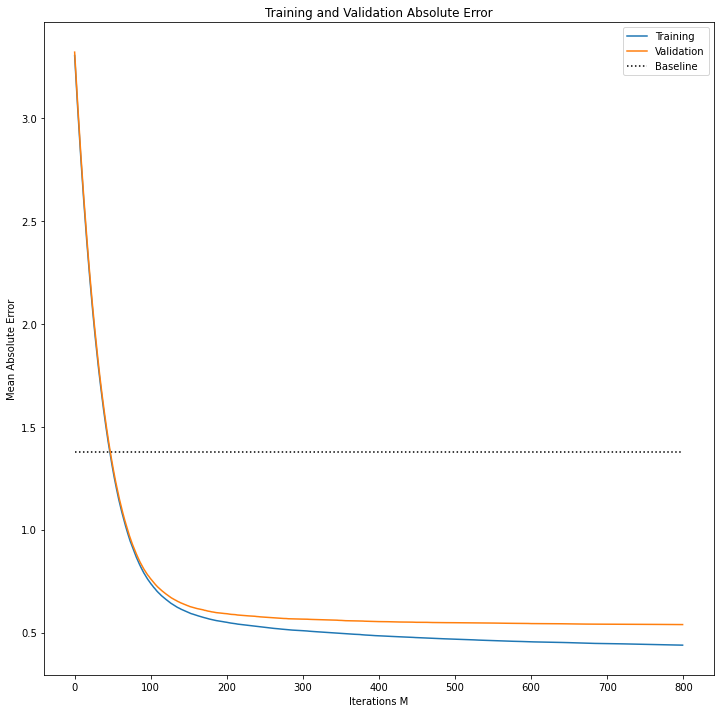

In [ ]:
#Thanks to https://setscholars.net/wp-content/uploads/2019/02/visualise-XgBoost-model-with-learning-curves-in-Python.html

results = best_xgb.evals_result()
epochs = len(results['validation_0']['mae']) 
x_axis = range(0, epochs)


fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['mae'], label='Training')
ax.plot(x_axis, results['validation_1']['mae'], label='Validation')

plt.hlines(baseline_abserr, 0, 800, colors='black', linestyles='dotted', label='Baseline')    
ax.legend()
    
plt.ylabel('Mean Absolute Error')
plt.xlabel('Iterations M')
plt.title('Training and Validation Absolute Error')
plt.show()


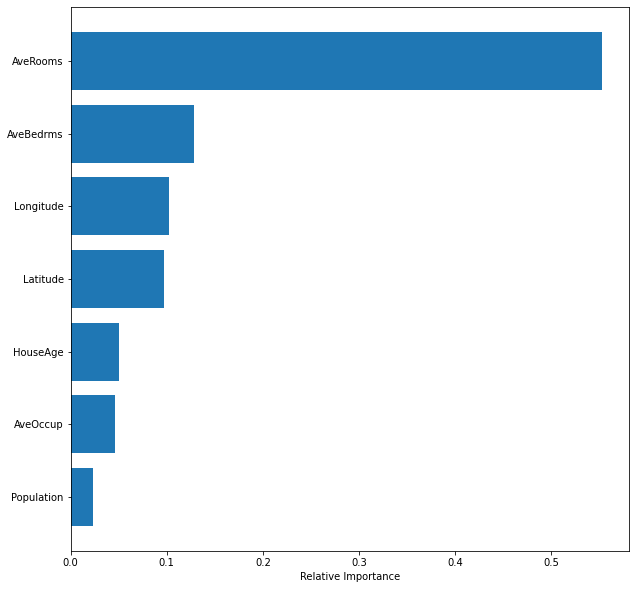

In [ ]:
feat = best_xgb.feature_importances_
names = sklearn_housing['feature_names'][1:]


feat, names = zip(*sorted(zip(feat, names)))
plt.figure(figsize=(10,10))
plt.barh( names, feat)
plt.xlabel('Relative Importance')
plt.show()

##Second Dataset: 

In [ ]:
#in this dataset, we want to try to predict the critical temperature of
#a potential superconducter, using a variety of material properties relating
#to mass, size, conductivity, entropy, thermal properties etc...

df_super = pd.read_csv('train.csv')

#The dataset has 81 features, the first time we trained the model it took over half an hour
#and most of the variables were completely insignificant with a relative importance near 0.
#So here we preselected the 10 variables with the highest relative importance.
df_super = df_super[['range_ThermalConductivity', 'range_atomic_radius', 'wtd_std_ThermalConductivity',
                  'wtd_gmean_ThermalConductivity', 'wtd_std_ElectronAffinity','std_atomic_mass',
                  'wtd_range_ElectronAffinity', 'std_Density', 'gmean_ElectronAffinity','wtd_mean_Valence'
                  ,'critical_temp']]

super = df_super.to_numpy()
df_super.head()

,range_ThermalConductivity,range_atomic_radius,wtd_std_ThermalConductivity,wtd_gmean_ThermalConductivity,wtd_std_ElectronAffinity,std_atomic_mass,wtd_range_ElectronAffinity,std_Density,gmean_ElectronAffinity,wtd_mean_Valence,critical_temp
0,399.97342,205,138.517163,0.621979,42.558396,51.968828,80.987143,3306.162897,60.123179,2.257143,29.0
1,429.97342,205,139.630922,0.619735,41.667621,47.094633,81.207857,3767.403176,69.833315,2.257143,26.0
2,399.97342,205,138.540613,0.619095,41.639878,51.968828,81.207857,3306.162897,60.123179,2.271429,19.0
3,399.97342,205,138.528893,0.620535,42.102344,51.968828,81.097500,3306.162897,60.123179,2.264286,22.0
4,399.97342,205,138.493671,0.624878,43.452059,51.968828,80.766429,3306.162897,60.123179,2.242857,23.0


In [ ]:
#Critical Temperature is in the last column of the dataset
split_data = train_val_test_split(super[:,:-1],
                                  super[:,-1],
                                  PERCENT_TEST,
                                  PERCENT_VAL,
                                  random_state)
#unpacking
X_train, X_val, X_test, y_train, y_val, y_test = split_data

#printing sizes to check
print('Input length:', len(super))
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))

Input length: 21263
Number of training samples: 17031
Number of validation samples: 2105
Number of testing samples: 2127


In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.02, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=800,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=True, subsample=1,
                                 

In [ ]:
best_xgb = random_search.best_estimator_
eval_sets = [(X_train, y_train), (X_val, y_val)]
best_xgb.fit(X_train, y_train,
             eval_metric='mae',
             eval_set=eval_sets,
             verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=800,
             n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [ ]:
baseline_abserr = np.mean( np.abs(y_val - y_train.mean()) )
baseline_abserr

29.792239293312555

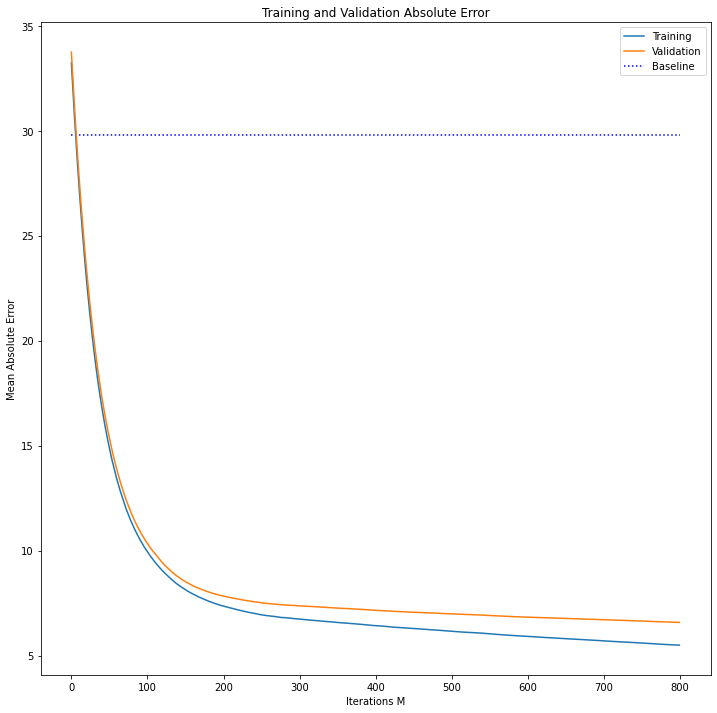

In [ ]:
results = best_xgb.evals_result()
epochs = len(results['validation_0']['mae']) 
x_axis = range(0, epochs)


fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['mae'], label='Training')
ax.plot(x_axis, results['validation_1']['mae'], label='Validation')

plt.hlines(baseline_abserr, 0, 800, colors='b', linestyles='dotted', label='Baseline')    
ax.legend()

plt.ylabel('Mean Absolute Error')
plt.xlabel('Iterations M')
plt.title('Training and Validation Absolute Error')
plt.show()

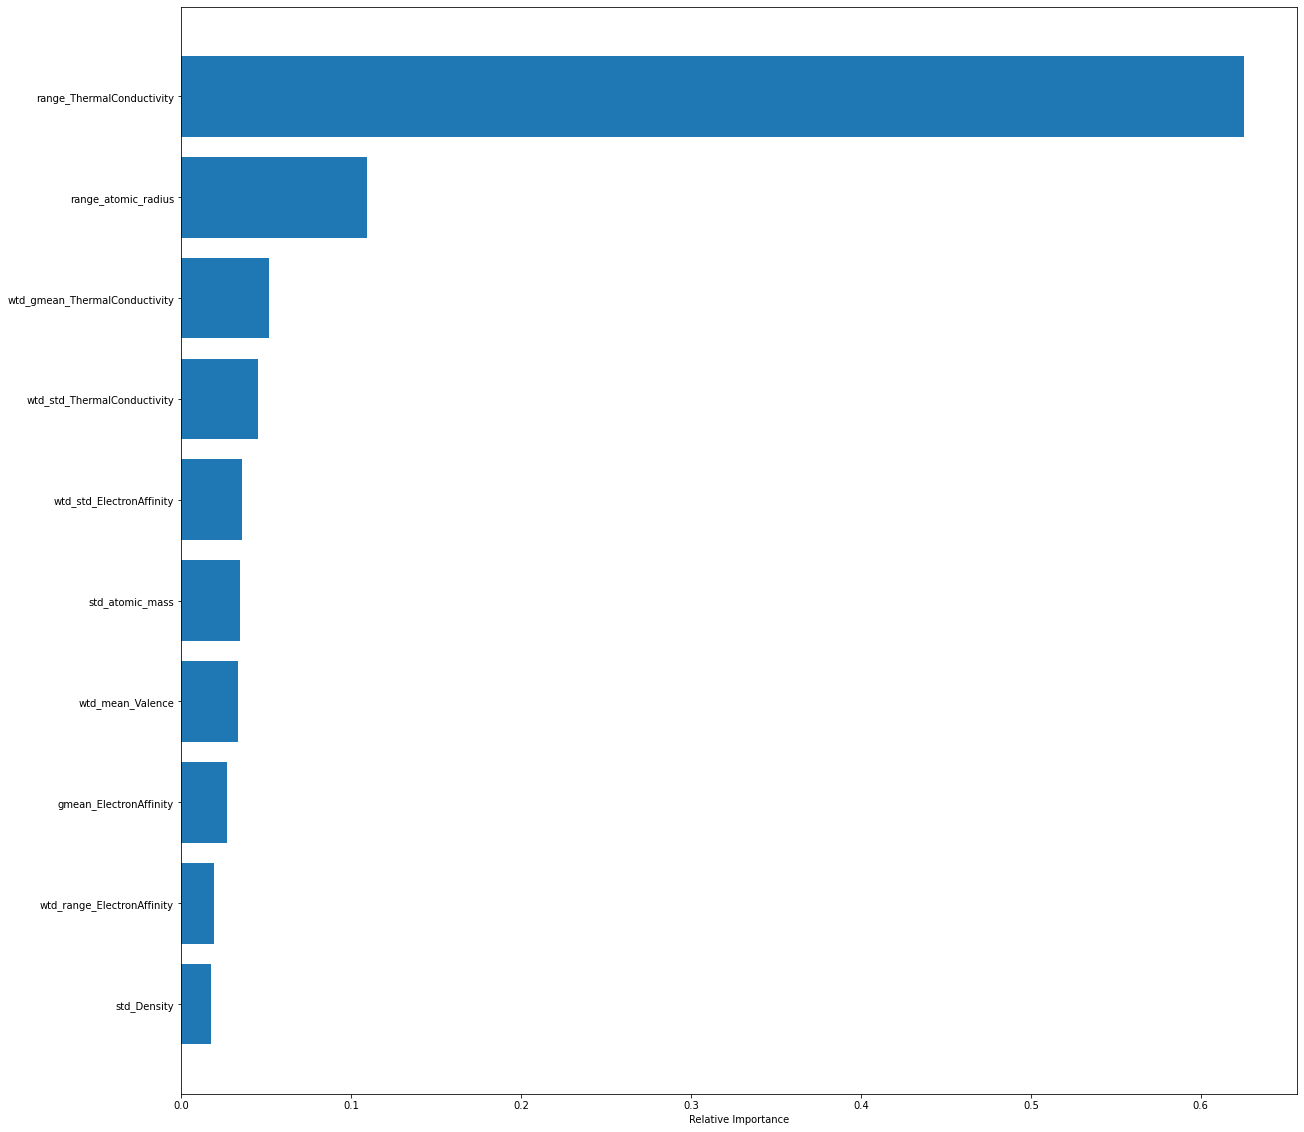

In [ ]:
feat = best_xgb.feature_importances_
names = list(df_super.columns)

feat, names = zip(*sorted(zip(feat, names)))
plt.figure(figsize=(20,20))
plt.barh( names, feat)
plt.xlabel('Relative Importance')
plt.show()

The first time we ran this on the entire dataset (with 81 features), the randomized search (grid search alternative) took over half an hour to run. In the end, the vast majority of features were completely irrelevant (some didn't even get splits in the tree) so we decided to take only the ten most important features to make future testing easier, and to improve the overall model.

##Stretch Goals

In [ ]:
import statistics as stat

In [ ]:
#Thanks to https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

class tree():
  def __init__(self, loss, max_depth, isreg  = True):
    self.loss = loss
    self.max_depth = max_depth
    self.root = None
    self.reg = isreg

  # Split a dataset based on an attribute and an attribute value
  def test_split(self, index, value, dataset):
    left, right = list(), list()
    for row in dataset:
      if row[index] < value:
        left.append(row)
      else:
        right.append(row)
    return left, right

  # Select the best split point for a dataset
  def get_split(self, dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
      for row in dataset:
        groups = self.test_split(index, row[index], dataset)
        score = self.loss(groups, class_values)
        if score < b_score:
          b_index, b_value, b_score, b_groups = index, row[index], score, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

  # Create a terminal node value
  def to_terminal(self, group):
    outcomes = [row[-1] for row in group]
    if self.reg:
      return sum(outcomes)/len(outcomes)
    else:
      return stat.mode(outcomes)

  # Create child splits for a node or make terminal
  def split(self, node, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
      node['left'] = node['right'] = self.to_terminal(left + right)
      return
    # check for max depth
    if depth >= self.max_depth:
      node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
      return

    node['left'] = self.get_split(left)
    self.split(node['left'],  depth+1)
    node['right'] = self.get_split(right)
    self.split(node['right'], depth+1)
    return 


  # Fit the data
  def fit(self, X,y):
    #numpy to formatted input
    data = np.concatenate((X,y.reshape(-1,1)), axis = 1).tolist()   

    self.root = self.get_split(data)
    self.split(self.root, 1)
    return self.root

  # Make a prediction with a decision tree
  def predict(self, X):
    def predict_(node, X):
        if row[node['index']] < node['value']:
          if isinstance(node['left'], dict):
            return (predict_(node['left'], row))
          else:
            return node['left']
        else:
          if isinstance(node['right'], dict):
            return (predict_(node['right'], row))
          else:
            return node['right']
    data = X.tolist()   
    pred = []
    for row in data:
      pred.append(predict_(self.root, row))
    return pred


In [ ]:
!wget -O iris.data https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2020-10-22 05:46:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data’

iris.data           100%[===================>]   4.44K  --.-KB/s    in 0s      

2020-10-22 05:46:28 (84.1 MB/s) - ‘iris.data’ saved [4551/4551]



In [ ]:
#reading the data into a numpy array of floats
header = ['sepal length','sepal width', 'petal length', 'petal width', 'classes']

iris_df = pd.read_csv('iris.data', names = header)
#text to numerical

class_labels = iris_df.classes.unique()
for i, label in enumerate(class_labels):
  iris_df.classes[iris_df.classes == label] = i

iris = iris_df.to_numpy().astype('float')
iris_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,sepal length,sepal width,petal length,petal width,classes
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
X = iris[:,:-1]
y = iris[:,-1]
t = tree(gini_index, 5)
tree = t.fit(X,y)

In [ ]:
np.mean((np.round(t.predict(X))-y) != 0)

0.02666666666666667

Classification error rate is 2.6% for a max depth of 3, 0.6% for a depth of 4, and goes to 0% for 5 and above.